In [1]:
import os
import glob
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.fft import fft
from data import DivideData

In [2]:
class UnsupervisedClassify():
    
    def __init__(self, base_dir):
        self.base_dir = base_dir
        self.tasks = pd.read_csv('/home/Shared/xinyi/blob1/thesis/data/task.csv')
    def rx_values(self, i_values, q_values):
        """
        use to merge the i and q channels
        :param i_values: e.g.'rx1_freq_a_channel_i_data'
        :param q_values: e.g.'rx1_freq_a_channel_q_data'
        :return: merged channels and i and q channels (flattened)
        """
        a1i = np.array([np.array(row) for row in i_values])
        a1q = np.array([np.array(row) for row in q_values])

        n = np.array(range(256)) / 256
        f_c = 24_000_000_000  # 24 GHz
        v = 2.0 * np.pi * f_c * n

        value_rx = a1i * np.cos(v) + a1q + np.sin(v)
        return value_rx, a1i, a1q

    def prepare_merged_channels(self, dt):
        rx1_a_i = dt['rx1_freq_a_channel_i_data']
        rx1_a_q = dt['rx1_freq_a_channel_q_data']
        rx2_a_i = dt['rx2_freq_a_channel_i_data']
        rx2_a_q = dt['rx2_freq_a_channel_q_data']
        rx1_b_i = dt['rx1_freq_b_channel_i_data']
        rx1_b_q = dt['rx1_freq_b_channel_q_data']
        # merge!
        a1_rx, a1_i_values, a1_q_values = self.rx_values(i_values=rx1_a_i, q_values=rx1_a_q)
        a2_rx, a2_i_values, a2_q_values = self.rx_values(i_values=rx2_a_i, q_values=rx2_a_q)
        b1_rx, b1_i_values, b1_q_values = self.rx_values(i_values=rx1_b_i, q_values=rx1_b_q)  
        # return a1_rx, a2_rx, b1_rx do need this step for adding them to the df !!!
        a1_rx_nested_arr = a1_rx.tolist()
        a2_rx_nested_arr = a2_rx.tolist()
        b1_rx_nested_arr = b1_rx.tolist()

        return a1_rx_nested_arr, a2_rx_nested_arr, b1_rx_nested_arr

    def flatten_df(self, df):
        df = df.iloc[:, :6]
        a1_rx, a2_rx, b1_rx = self.prepare_merged_channels(df)
        df['a1_rx'] = a1_rx
        df['a2_rx'] = a2_rx
        df['b1_rx'] = b1_rx
        part_arr = np.empty((9, 1), dtype=object)

        k = 0
        for col in df.columns:
            data_series = df[col]
            data_series_exploded = data_series.explode(col)
            merged_list = data_series_exploded.tolist()
            part_arr[k, 0] = merged_list
            k += 1
        df_new = pd.DataFrame(part_arr.T, columns=df.columns)
        return df_new
    def divide_task_index(self, participant):
        """
        for each participant df, annotate by tasks
        task info: T_1: uuid, T_2: uuid, ...
        :param participant: df for one participant
        :return: dictionary of {T_1: [position], T_2: [position], ...}
        """
        tasks = self.tasks
        task_index = {}
        # need to change the number of range according to the task number
        for i in range(15):
            T = participant[participant['task_uuid'] == tasks['UUID'][i]].index
            T = np.array(T) * 256
            task_index[f'T_{i}'] = T

        try:
            task_max = {key: value[-1] for key, value in task_index.items()}
            task_min = {key: value[0] for key, value in task_index.items()}
            merged_ind = {key: (task_min[key], task_max[key]) for key in task_index.keys()}
            return merged_ind
        except:
            print("cannot find task index")


In [17]:
class PCAandKMeans():
    def __init__(self):
        self.roi_task = ['T_0', 'T_1', 'T_2', 'T_3', 'T_4', 'T_5', 'T_6', 'T_7', 'T_8', 'T_9', 'T_10']
    def apply_fft(self, row):
        fft_result = fft(row)
        fft_magnitude = np.abs(fft_result)
        fft_magnitude_no_dc = fft_magnitude[1:len(fft_result)//2]
        return fft_magnitude_no_dc
        
    def plot_PCA(self, components, mean_values):
        plt.plot(mean_values, linestyle='--', color='red', linewidth=2)
        plt.plot(components[:, :3], alpha=0.5)
        #plt.plot(components)
        plt.grid(False)
        plt.show()
        
    def apply_PCA(self, df_new, n_tasks):
        fft_for_pca = df_new['fft_result']
        min_length = min(fft_for_pca.apply(len))
        fft_for_pca = np.array(fft_for_pca)
        truncated_arrays = np.array([arr[:min_length] for arr in fft_for_pca])
        pca = PCA(n_components=11)
        components = pca.fit_transform(truncated_arrays)
        mean_values = np.mean(components[:, :3], axis=1)
        top_indices = np.argsort(mean_values)[-n_tasks:][::-1]  # Get the last four indices and reverse them for descending order

        # Print the indices of the top four tasks
        print("Indices of the top three tasks:", top_indices)
        top_tasks_df = df_new[df_new['task'].isin(top_indices)]
        self.plot_PCA(components, mean_values)
        return top_tasks_df
        
    def fft_df(self, part_1, n_tasks):
        part_1 = part_1.reset_index(drop=True)
        task_index = unsupervied_classify.divide_task_index(part_1)
        col = 'rx1_freq_a_channel_i_data'
        task_arr = np.empty((11, 1), dtype=object)
    
        for key, value in task_index.items():
            try:
                if key in self.roi_task:# key: T_0, T_1, ...
                    start, end = value
                    task_num = int(key.split('_')[1])
                    data_series = part_1[col]
                    data_series_exploded = data_series.explode(col)
                    merged_list = data_series_exploded.tolist()
                    task_l = merged_list[start:(end+1)]
                    task_arr[task_num, 0] = task_l
            except Exception as e:
                print(f"Error processing task {key}: {e}")
                continue
        if any(task_arr[:, 0]):
            df_new = pd.DataFrame(task_arr)
            df_new['task'] = df_new.index
            df_new.rename(columns={df_new.columns[0]: 'rx1_freq_a_channel_i_data'}, inplace=True)
            df_new['fft_result'] = df_new['rx1_freq_a_channel_i_data'].apply(self.apply_fft)
            top_tasks_df = self.apply_PCA(df_new, n_tasks)
            return top_tasks_df
    def Kmeans_result(self, df_new, n_cluster):
        kmeans = KMeans(n_clusters=n_cluster, random_state=42)
        fft_for_pca = df_new['fft_result']
        min_length = min(fft_for_pca.apply(len))
        fft_for_pca = np.array(fft_for_pca)
        truncated_arrays = np.array([arr[:min_length] for arr in fft_for_pca])
        kmeans.fit(truncated_arrays)
        labels = kmeans.labels_
        df_new[f'clusters_{n_cluster}'] = labels

        # statistics
        cluster_task_counts = df_new.groupby(f'clusters_{n_cluster}')['task'].nunique().reset_index()
        cluster_task_counts.columns = ['Cluster', 'Number of Unique Tasks']
        # Count occurrences of each task in each cluster
        task_cluster_counts = df_new.groupby([f'clusters_{n_cluster}', 'task']).size().unstack(fill_value=0)
        
        # Plotting
        # Define color mapping
        color_mapping = {0: 'blue', 6: 'pink', 7: 'green'}
        default_color = 'gray'
        
        # Generate color list based on task columns
        colors = [color_mapping.get(task, default_color) for task in task_cluster_counts.columns]
        
        plt.figure(figsize=(12, 8))
        task_cluster_counts.plot(kind='bar', stacked=True, color=colors, ax=plt.gca())
        plt.title(f'Task Distribution Across K-Means cluster = {n_cluster}')
        plt.xlabel('Cluster')
        plt.ylabel('Number of Tasks')
        plt.xticks(rotation=0)  # Rotate x labels for better readability

        # Custom legend setup
        unique_tasks = [0, 6, 7]  # Specify unique tasks to show individually
        legend_labels = ["Task 0", "Task 6", "Task 7", "Other Tasks"]
        handles = [plt.Line2D([0], [0], color=color_mapping.get(task, default_color), linewidth=10) for task in unique_tasks]
        handles.append(plt.Line2D([0], [0], color=default_color, linewidth=10))  # Add single "Other Tasks" entry
    
        plt.legend(handles=handles, labels=legend_labels, title="Task", bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()

chose top three components, and extracted the top four tasks according to the PCA score

Indices of the top three tasks: [7 8 0]


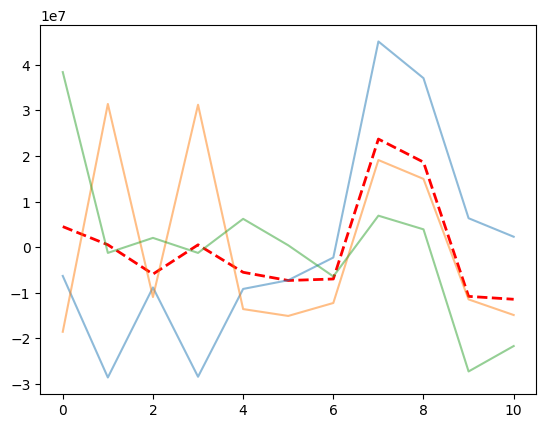

Indices of the top three tasks: [0 7 6]


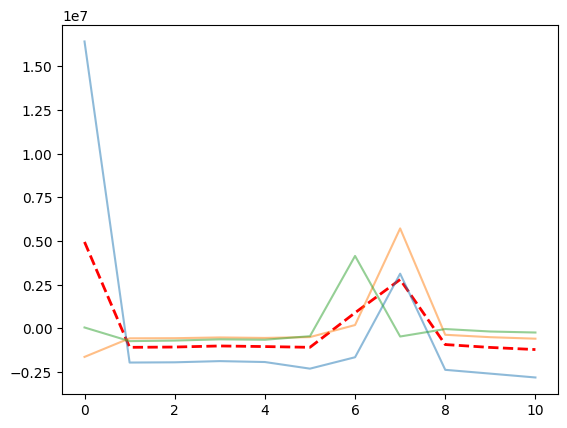

Indices of the top three tasks: [7 0 2]


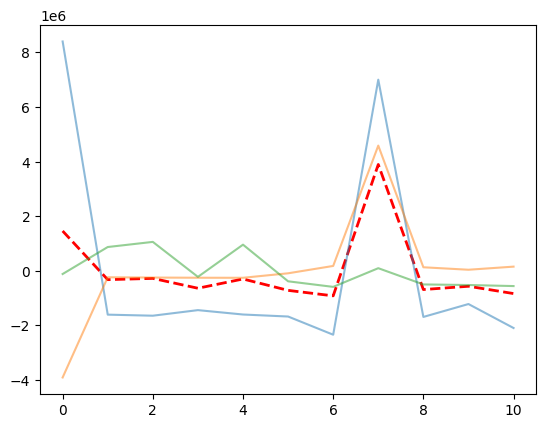

Indices of the top three tasks: [0 7 6]


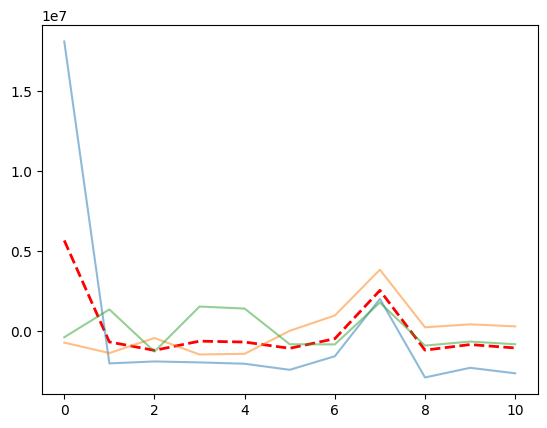

Indices of the top three tasks: [7 0 9]


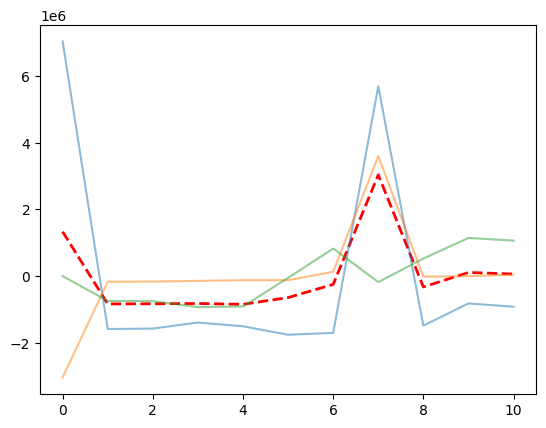

Indices of the top three tasks: [0 7 4]


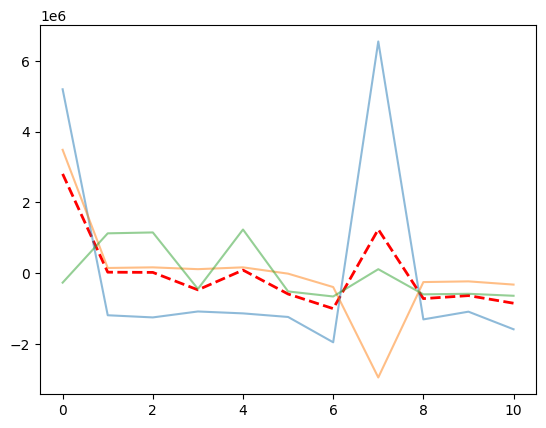

Indices of the top three tasks: [7 0 2]


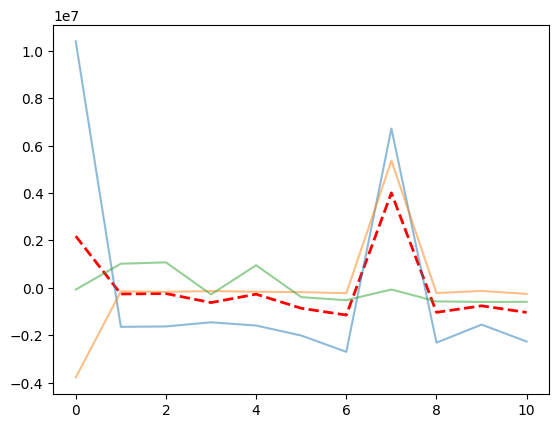

Indices of the top three tasks: [7 0 1]


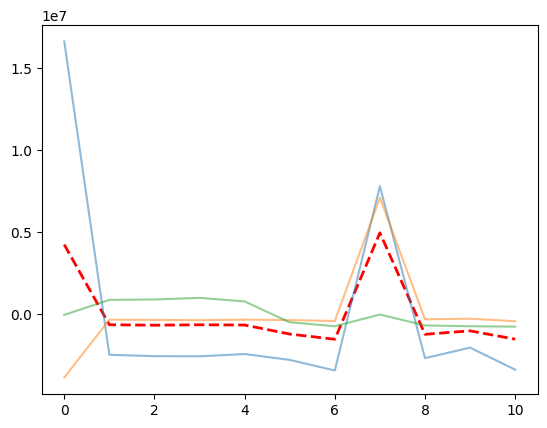

Indices of the top three tasks: [7 0 6]


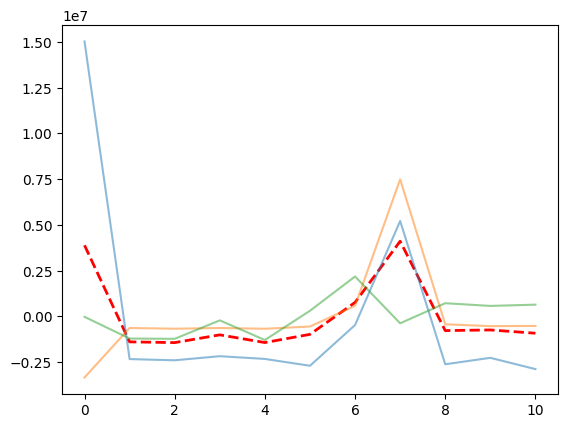

Indices of the top three tasks: [7 0 4]


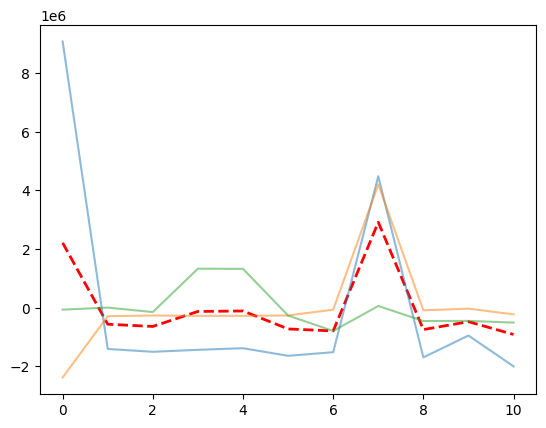

Indices of the top three tasks: [7 0 6]


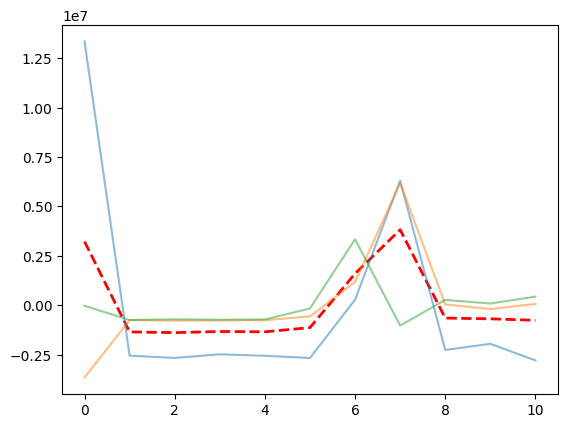

Indices of the top three tasks: [0 1 3]


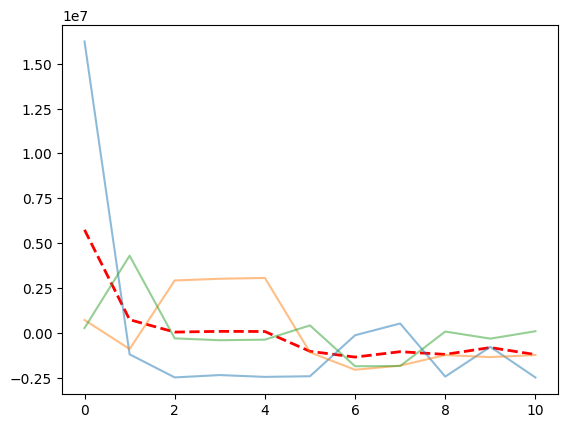

Indices of the top three tasks: [0 6 7]


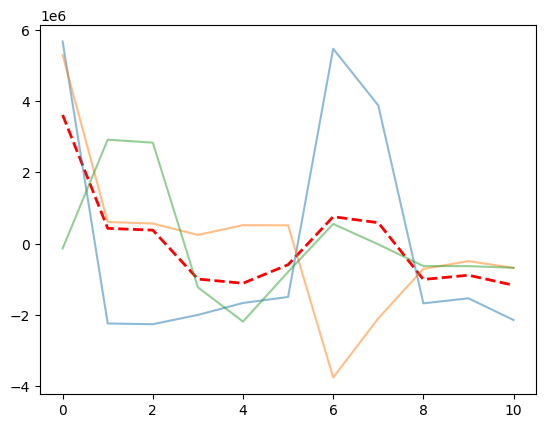

Indices of the top three tasks: [6 0 7]


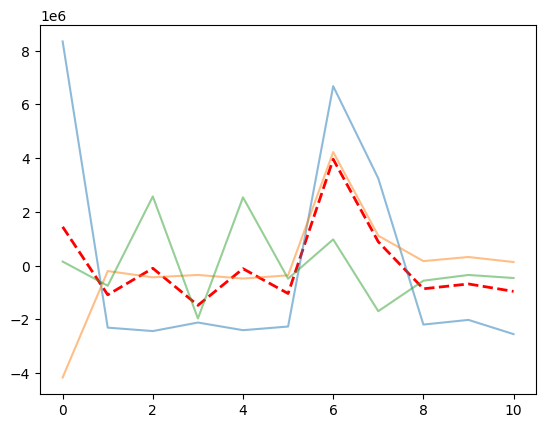

Indices of the top three tasks: [0 6 7]


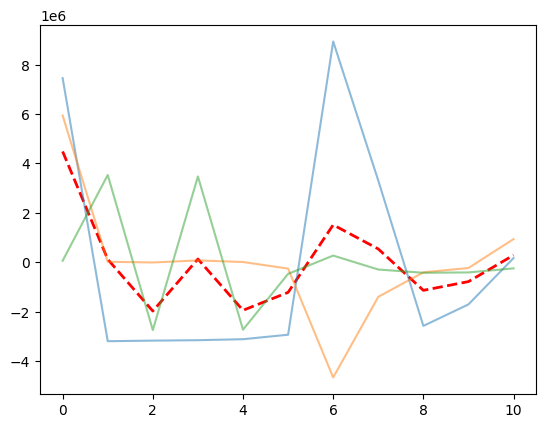

Indices of the top three tasks: [7 6 0]


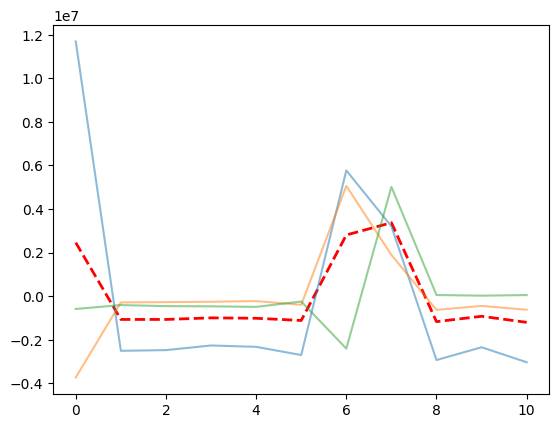

Indices of the top three tasks: [0 7 3]


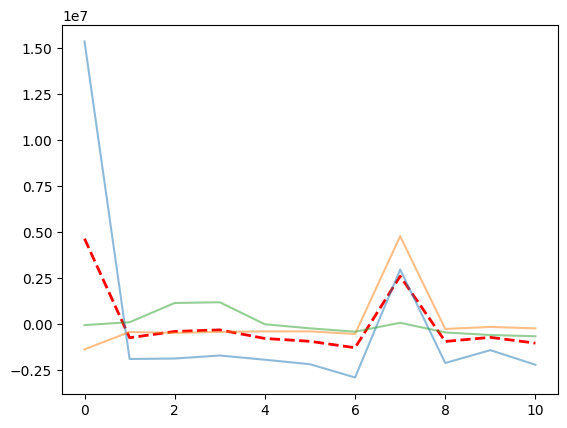

Indices of the top three tasks: [0 7 6]


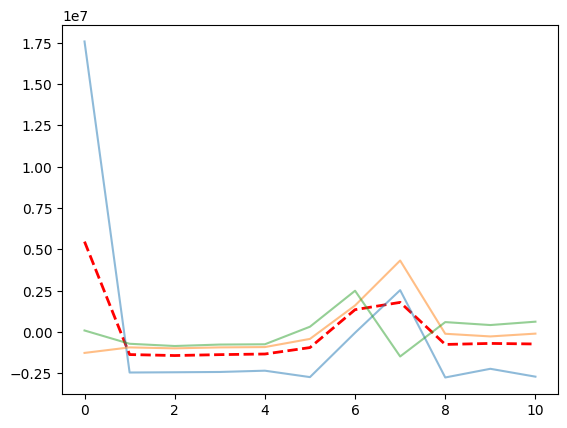

Indices of the top three tasks: [7 0 3]


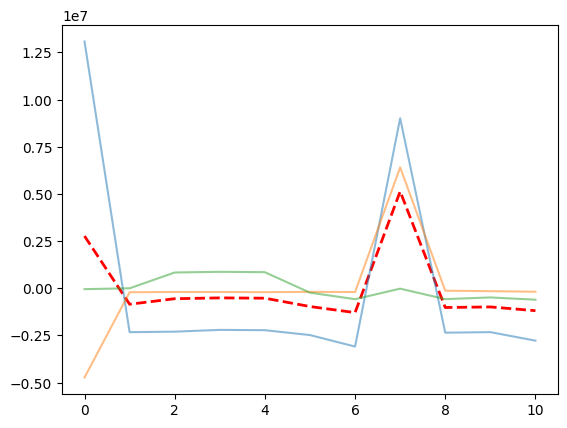

Indices of the top three tasks: [7 0 4]


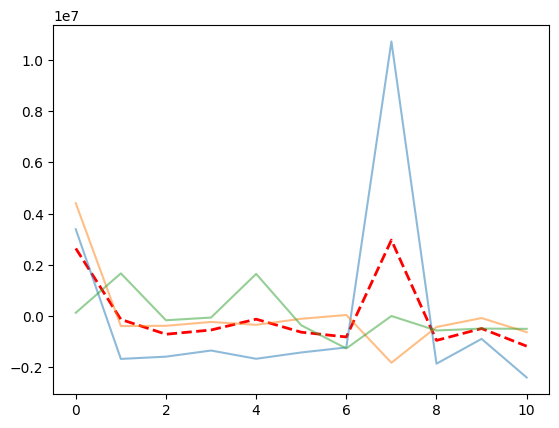

Indices of the top three tasks: [6 7 0]


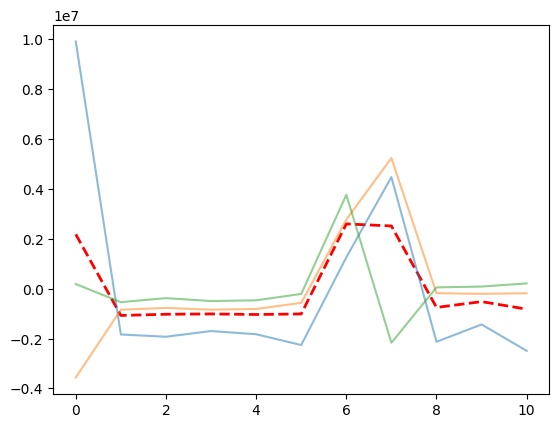

Indices of the top three tasks: [0 7 3]


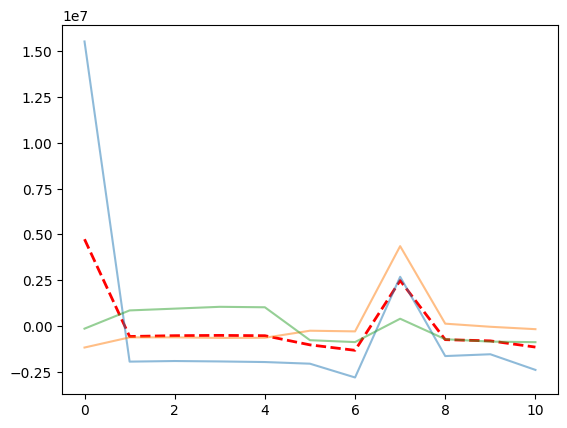

Indices of the top three tasks: [7 0 1]


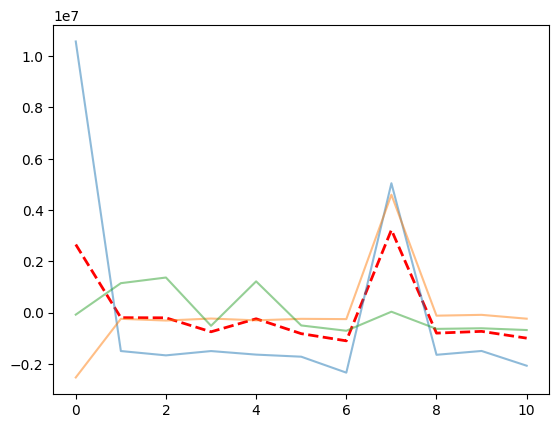

Indices of the top three tasks: [3 2 6]


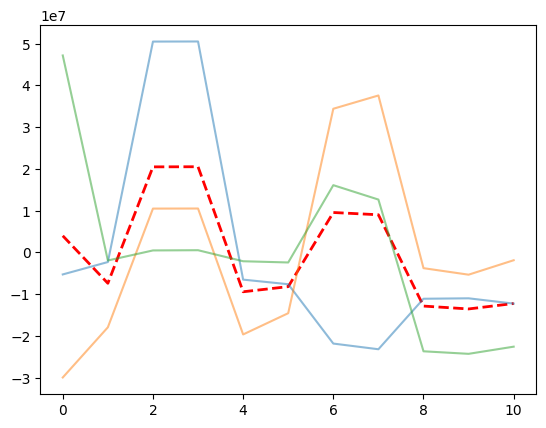

Indices of the top three tasks: [7 0 6]


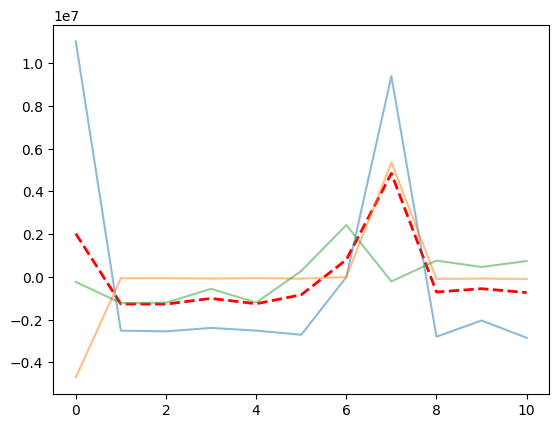

Indices of the top three tasks: [7 9 0]


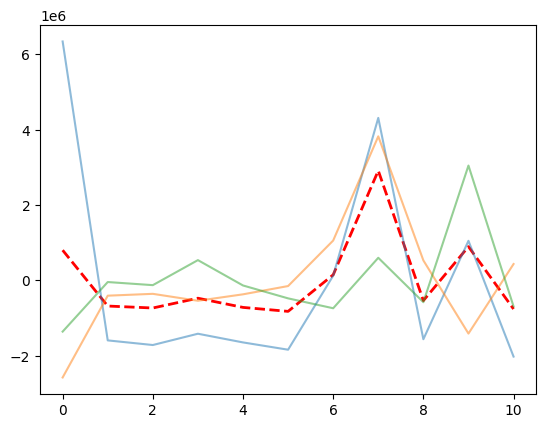

Indices of the top three tasks: [0 7 1]


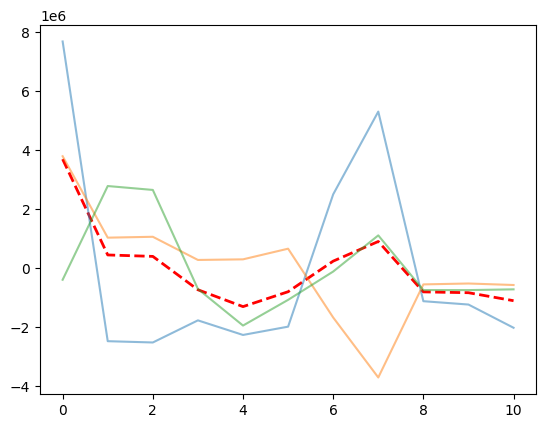

Indices of the top three tasks: [6 0 7]


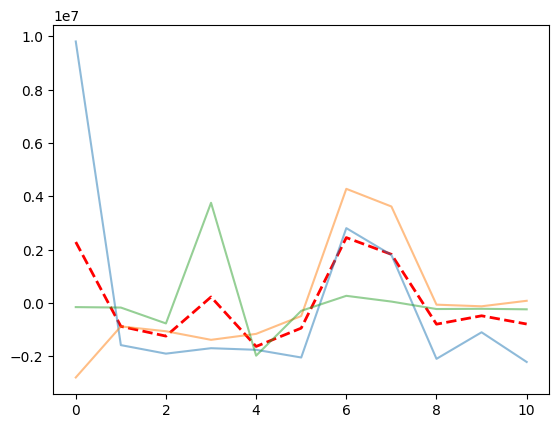

Indices of the top three tasks: [0 6 7]


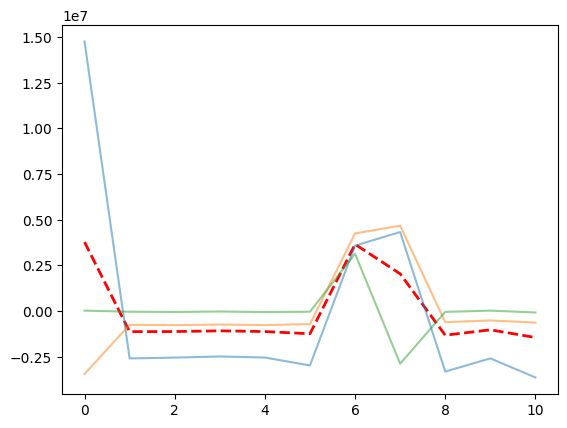

Indices of the top three tasks: [0 7 6]


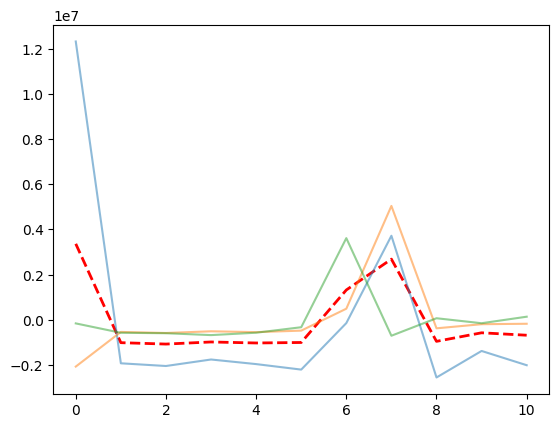

cannot find task index


AttributeError: 'NoneType' object has no attribute 'items'

In [6]:
pca_kmeans = PCAandKMeans()
radar_no = 112

# Set the base path, subfolders, and task filename
base_dir = '/home/Shared/xinyi/blob1/thesis/data/parquet_samples/'
unsupervied_classify = UnsupervisedClassify(base_dir)

# Define the file pattern to search for radar files
file_pattern = os.path.join(base_dir, '**', f'radar_samples_192.168.67.{radar_no}*')
matching_files = glob.glob(file_pattern, recursive=True)

# Initialize an empty list to collect results
all_participants_results = []

# Iterate through each matching file
for data_path in matching_files:
    divide_data = DivideData(data_path) 
    part, num = divide_data.divide_participants() 
    for key, value in enumerate(part):
        data_part = part[value]
        pca_results = pca_kmeans.fft_df(data_part, 3) 
        all_participants_results.append(pca_results)

In [7]:
df_all_participants = pd.concat(all_participants_results, ignore_index=True)
df_all_participants

,rx1_freq_a_channel_i_data,task,fft_result
0,"[34288.0, 34368.0, 34288.0, 34336.0, 34272.0, ...",0,"[478145.28, 323318.62, 210751.69, 112091.62, 2..."
1,"[33408.0, 33408.0, 33456.0, 33616.0, 33824.0, ...",7,"[251727.53, 41377.766, 275073.94, 117093.38, 3..."
2,"[34128.0, 34272.0, 34224.0, 34256.0, 34176.0, ...",8,"[224408.33, 47412.51, 240969.8, 118807.164, 29..."
3,"[33952.0, 34192.0, 34128.0, 33952.0, 34000.0, ...",0,"[51398.906, 9460.027, 60579.035, 59035.117, 10..."
4,"[34224.0, 34208.0, 34208.0, 34160.0, 34160.0, ...",6,"[19031.547, 5314.3506, 14254.583, 11489.94, 65..."
...,...,...,...
85,"[34160.0, 34288.0, 34208.0, 34048.0, 34048.0, ...",6,"[58308.156, 43031.895, 30642.166, 32299.943, 4..."
86,"[34080.0, 34192.0, 34224.0, 34192.0, 34144.0, ...",7,"[44335.8, 39553.598, 8110.0586, 22193.816, 239..."
87,"[33104.0, 32976.0, 32944.0, 32880.0, 32848.0, ...",0,"[40906.14, 39257.723, 30582.172, 73102.87, 416..."
88,"[34096.0, 34160.0, 34096.0, 34112.0, 34128.0, ...",6,"[3568.4363, 17142.713, 20908.635, 34856.176, 6..."


In [18]:
pca_kmeans = PCAandKMeans()

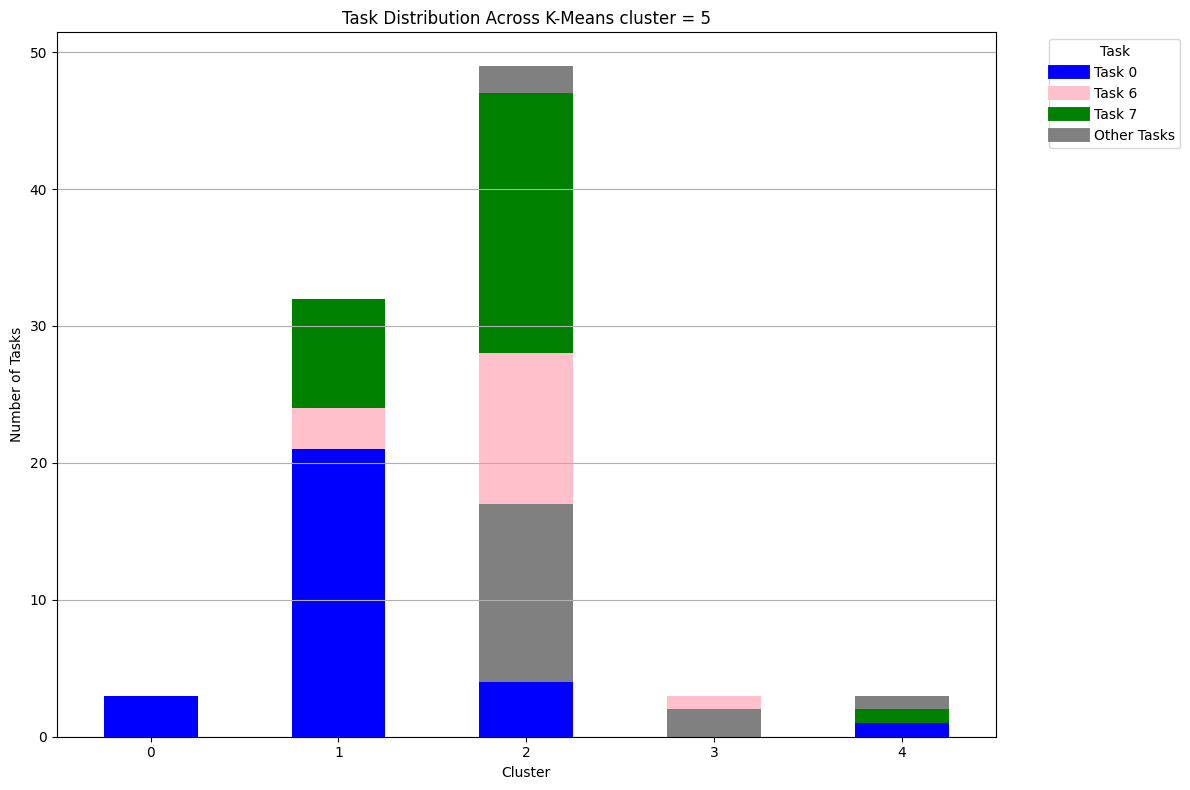

In [19]:
pca_kmeans.Kmeans_result(df_new=df_all_participants, n_cluster=5)

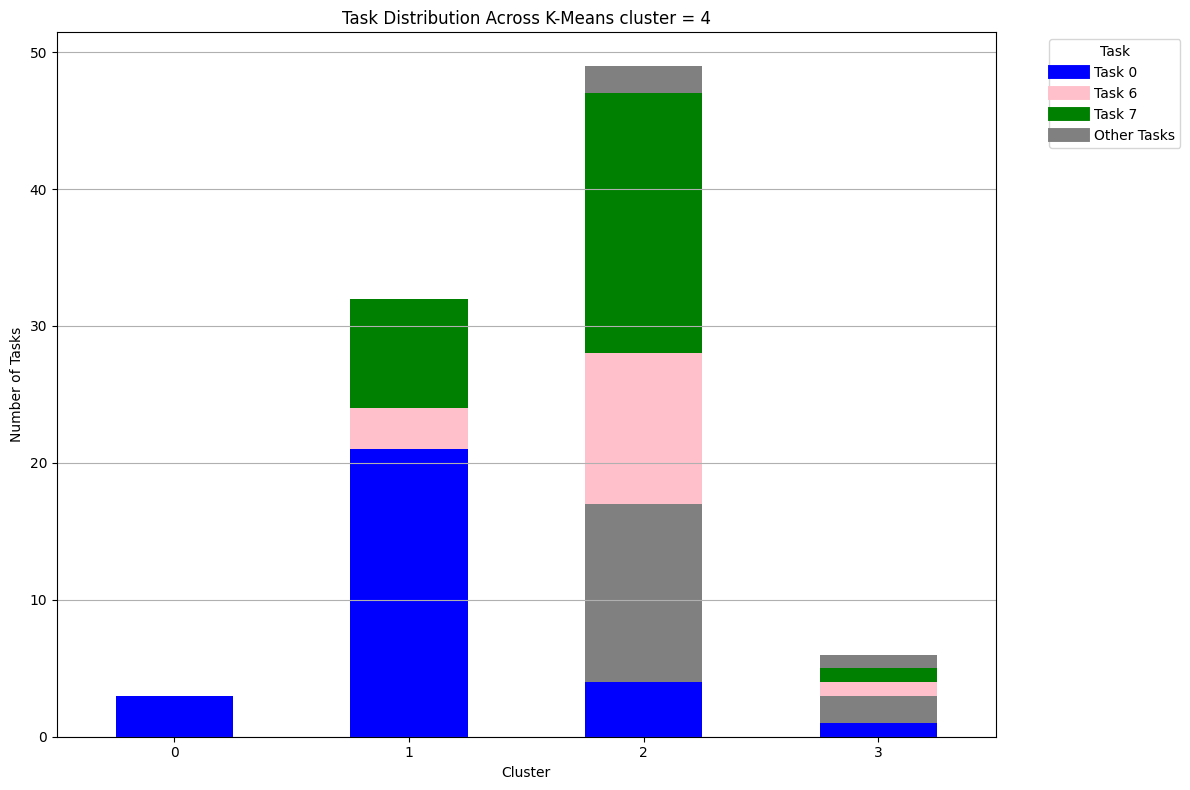

In [20]:
pca_kmeans.Kmeans_result(df_new=df_all_participants, n_cluster=4)

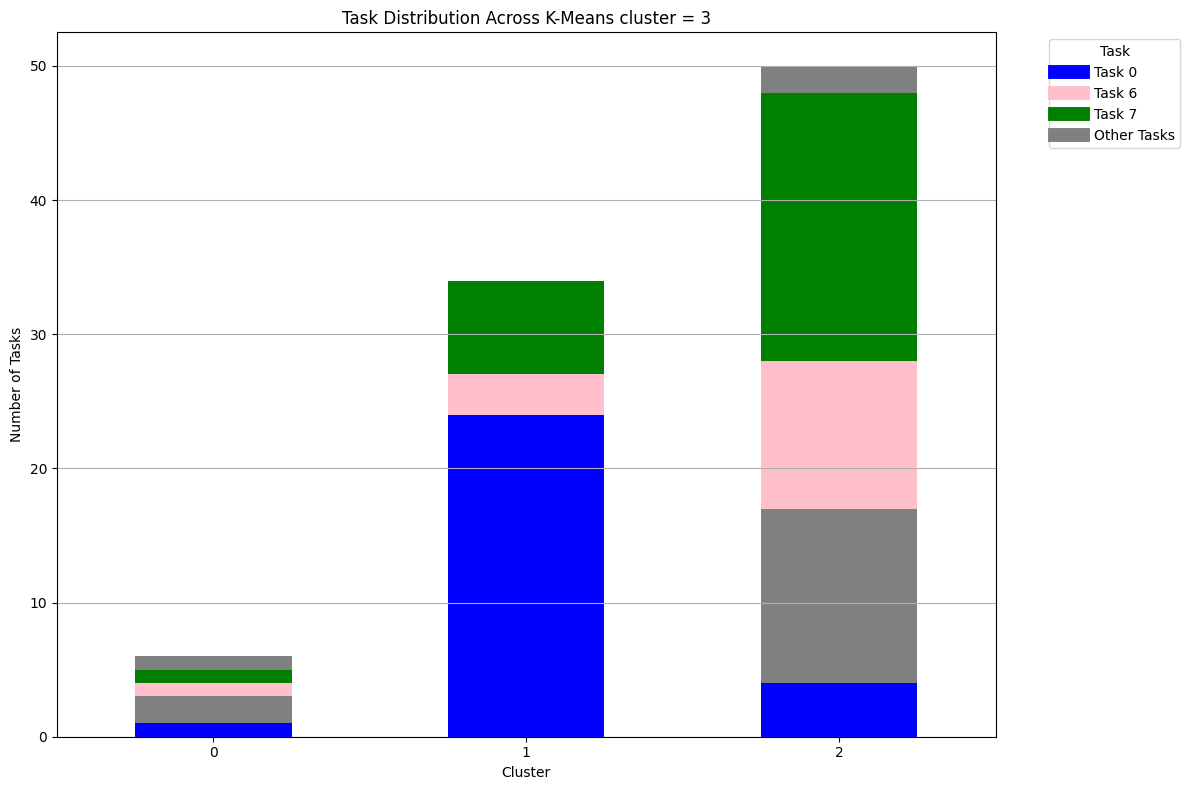

In [21]:
pca_kmeans.Kmeans_result(df_new=df_all_participants, n_cluster=3)

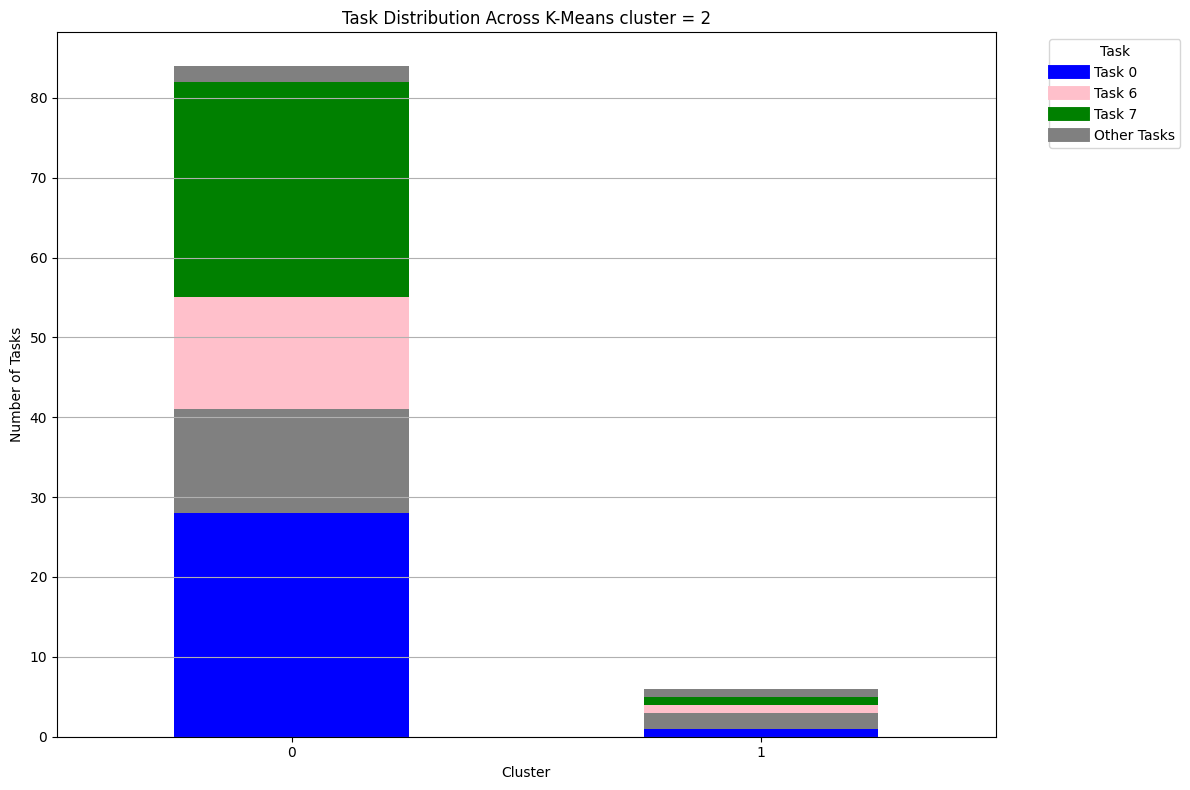

In [22]:
pca_kmeans.Kmeans_result(df_new=df_all_participants, n_cluster=2)